In [4]:
import tifffile
from pathlib import Path
import json
import numpy as np
from PIL import Image, TiffTags
from pprint import pprint
import re
import os
import matplotlib.pyplot as plt

import kikuchipy as kp
from openECCI import optimization, util, io, rkp

In [11]:
pwd

'C:\\Users\\westraadt.1\\DataProcessing\\RAM280\\20241215'

In [5]:
# Function to split numbers and units
def split_number_unit(value):
    match = re.match(r"([0-9.]+)([a-zA-Z]*)", value)
    if match:
        number = match.group(1)
        unit = match.group(2)
        return number, unit
    else:
        return value, ''

# Open the file in read mode
def read_JEOLtxt(filename):
    data_dict = {}
    with open(filename, 'r') as file:
        # Read the contents of the file line by line
        for line in file:
            # Strip any leading/trailing whitespace characters
            line = line.strip()
            # Split the line into key and values
            parts = line.split()
            key = parts[0]
            values = parts[1:] if len(parts) > 1 else ['0']
            # Split numbers and units for each value
            split_values = [split_number_unit(value) for value in values]
            # Add the key and split values to the dictionary
            data_dict[key] = split_values

    sem_metadata = {
    "vendor": data_dict['$CM_FORMAT'][0][0],
    "stage_rot_angle": float(data_dict['$CM_STAGE_POS'][3][0]),
    "stage_tilt_angle": float(data_dict['$CM_STAGE_POS'][4][0]),
    "stage_x": float(data_dict['$CM_STAGE_POS'][0][0]),
    "stage_y": float(data_dict['$CM_STAGE_POS'][1][0]),
    "stage_z": float(data_dict['$CM_STAGE_POS'][2][0]),
    "resolution": [int(data_dict['$CM_FULL_SIZE'][0][0]), int(data_dict['$CM_FULL_SIZE'][1][0])],
    "pixel_size": float(data_dict['$$SM_MICRON_MARKER'][0][0]) / float(data_dict['$$SM_MICRON_BAR'][0][0]),
    "databar": True,
    "HV": float(data_dict['$SM_GB_GUN_VOLT'][0][0]),
    "WD": float(data_dict['$$SM_WD'][0][0]),
    "beam_current": float(data_dict['$$SM_PROBE_NO'][0][0]),
    "aperture_diameter": float(data_dict['$$SM_OL_APERTURE'][0][0]),
    "column_mode": data_dict['$$SM_COLUMN_MODE'][0][0],
    }
    
    return sem_metadata

In [14]:
def change_extension_to_txt(filename):
    # Split the filename into name and extension
    name, ext = os.path.splitext(filename)
    # Create a new name with a .txt extension
    new_filename = f"{name}.txt"
    return new_filename

def add_suffix_to_filename(filename, suffix='_m'):
    # Split the filename into name and extension
    name, ext = os.path.splitext(filename)
    # Create a new name with the suffix and the same extension
    new_filename = f"{name}{suffix}{ext}"
    return new_filename

def check_file_exists(file_path):
    return os.path.isfile(file_path)

def create_custom_jeol_tiff(filename):
    with tifffile.TiffFile(filename) as tif:
        image_data_read = tif.asarray()
        metadata = change_extension_to_txt(filename)
        if(check_file_exists(metadata)):
            data_dict = read_JEOLtxt(metadata)
            metadata_str = json.dumps(data_dict)
            outputfile = add_suffix_to_filename(filename)
            with tifffile.TiffWriter(outputfile) as tif:
                tif.write(image_data_read, description=metadata_str)
            print(f"Image data and metadata saved successfully for {filename}.")
        else:
            print(f"Image data and metadata not saved for {filename}.")

def create_custom_rkd_tiff(filename, metadata):
    with tifffile.TiffFile(filename) as tif:
        image_data_read = plt.imread(filename)
        data_dict = metadata
        metadata_str = json.dumps(data_dict)
        outputfile = add_suffix_to_filename(filename)
        with tifffile.TiffWriter(outputfile) as tif:
            tif.write(image_data_read[:,:,0], description=metadata_str)
        print(f"Image data and metadata saved successfully for {filename}.")
        
def show_tiff_metadata(file_path):
    with tifffile.TiffFile(file_path) as tif:
        for page in tif.pages:
            print(f"Page {page.index}:")
            for tag in page.tags.values():
                name, value = tag.name, tag.value
                print(f"  {name}: {value}")

def read_and_display_tiff(file_path):
    # Read the TIFF file
    with tifffile.TiffFile(file_path) as tif:
        image_data = tif.asarray()

    # Display the image
    plt.imshow(image_data, cmap='gray')
    plt.axis('off')  # Hide the axis
    plt.show()

Image data and metadata saved successfully for .\data\ECP_Si_3tilt_n5rot.tif.
Page 0:
  ImageWidth: 1280
  ImageLength: 1024
  BitsPerSample: 8
  Compression: 1
  PhotometricInterpretation: 1
  ImageDescription: {"vendor": "JEOL-SEM", "stage_rot_angle": 5.0, "stage_tilt_angle": 3.0, "stage_x": -9.618, "stage_y": 7.14, "stage_z": 8.8, "resolution": [1280, 960], "pixel_size": 0.8547008547008547, "databar": true, "HV": 20.0, "WD": 6.04, "beam_current": 13.0, "aperture_diameter": 4.0, "column_mode": "ECP"}
  ImageDescription: {"shape": [1024, 1280]}
  StripOffsets: (560,)
  SamplesPerPixel: 1
  RowsPerStrip: 1024
  StripByteCounts: (1310720,)
  XResolution: (1, 1)
  YResolution: (1, 1)
  ResolutionUnit: 1
  Software: tifffile.py


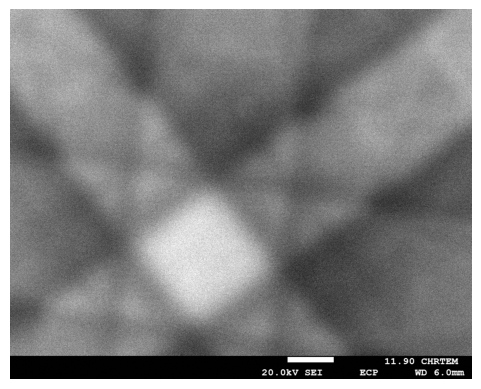

{'vendor': 'JEOL-SEM',
 'stage_rot_angle': 5.0,
 'stage_tilt_angle': 3.0,
 'stage_x': -9.618,
 'stage_y': 7.14,
 'stage_z': 8.8,
 'resolution': [1280, 960],
 'pixel_size': 0.8547008547008547,
 'databar': True,
 'HV': 20.0,
 'WD': 6.04,
 'beam_current': 13.0,
 'aperture_diameter': 4.0,
 'column_mode': 'ECP'}

In [7]:
create_custom_jeol_tiff(".\data\ECP_Si_3tilt_n5rot.tif")
show_tiff_metadata(".\data\ECP_Si_3tilt_n5rot_m.tif")
read_and_display_tiff(".\data\ECP_Si_3tilt_n5rot_m.tif")
test_metadata = io.get_sem_metadata(".\data\ECP_Si_3tilt_n5rot_m.tif")
test_metadata

In [8]:
test_metadata = io.get_sem_metadata(".\data\ECP_Si_3tilt_n5rot_m.tif")
test_metadata

{'vendor': 'JEOL-SEM',
 'stage_rot_angle': 5.0,
 'stage_tilt_angle': 3.0,
 'stage_x': -9.618,
 'stage_y': 7.14,
 'stage_z': 8.8,
 'resolution': [1280, 960],
 'pixel_size': 0.8547008547008547,
 'databar': True,
 'HV': 20.0,
 'WD': 6.04,
 'beam_current': 13.0,
 'aperture_diameter': 4.0,
 'column_mode': 'ECP'}

In [13]:
image_data_read = plt.imread("./data/13_26_25_pattern.tiff")
image_data_read[:,:,0].shape

(479, 479)

In [15]:
sem_metadata = {
    "vendor": "RKD",
    "stage_rot_angle": 0.0,
    "stage_tilt_angle": 0.0,
    "stage_x": 0.0,
    "stage_y": 0.0,
    "stage_z": 14.0,
    "resolution": [479, 479],
    "pixel_size": 1,
    "databar": False,
    "HV": 20.0,
    "WD": 14.0,
    "beam_current": 51.0,
    "aperture_diameter": 50,
    "column_mode": "ECP",
}

create_custom_rkd_tiff("./data/13_26_25_pattern.tiff", sem_metadata)


Image data and metadata saved successfully for ./data/13_26_25_pattern.tiff.


Page 0:
  ImageWidth: 479
  ImageLength: 479
  BitsPerSample: 8
  Compression: 1
  PhotometricInterpretation: 1
  ImageDescription: {"vendor": "RKD", "stage_rot_angle": 0.0, "stage_tilt_angle": 0.0, "stage_x": 0.0, "stage_y": 0.0, "stage_z": 14.0, "resolution": [479, 479], "pixel_size": 1, "databar": false, "HV": 20.0, "WD": 14.0, "beam_current": 51.0, "aperture_diameter": 50, "column_mode": "ECP"}
  ImageDescription: {"shape": [479, 479]}
  StripOffsets: (544,)
  SamplesPerPixel: 1
  RowsPerStrip: 479
  StripByteCounts: (229441,)
  XResolution: (1, 1)
  YResolution: (1, 1)
  ResolutionUnit: 1
  Software: tifffile.py


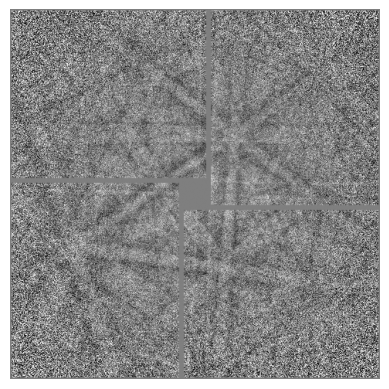

{'vendor': 'RKD',
 'stage_rot_angle': 0.0,
 'stage_tilt_angle': 0.0,
 'stage_x': 0.0,
 'stage_y': 0.0,
 'stage_z': 14.0,
 'resolution': [479, 479],
 'pixel_size': 1,
 'databar': False,
 'HV': 20.0,
 'WD': 14.0,
 'beam_current': 51.0,
 'aperture_diameter': 50,
 'column_mode': 'ECP'}

In [16]:
filename = "./data/13_26_25_pattern_m.tiff"
show_tiff_metadata(filename)
read_and_display_tiff(filename)
test_metadata = io.get_sem_metadata(filename)
test_metadata

In [18]:
def process_all_tiffs(directory):
    # List all TIFF files in the directory
    tiff_files = [f for f in os.listdir(directory) if f.endswith('.tif') or f.endswith('.tiff')]
    # Loop through each TIFF file and apply the function
    for tiff_file in tiff_files:
        file_path = os.path.join(directory, tiff_file)
        create_custom_tiff(file_path)

# Replace 'your_directory' with the path to your directory containing TIFF files
process_all_tiffs('./data')

Image data and metadata saved successfully for ./data\BSE_Ex_1000x.tif.
Image data and metadata not saved for ./data\BSE_Ex_1000x_m.tif.
Image data and metadata saved successfully for ./data\BSE_Ex_250x.tif.
Image data and metadata saved successfully for ./data\BSE_Ex_250x_b.tif.
Image data and metadata not saved for ./data\BSE_Ex_250x_b_m.tif.
Image data and metadata not saved for ./data\BSE_Ex_250x_m.tif.
Image data and metadata saved successfully for ./data\BSE_Ex_500x.tif.
Image data and metadata not saved for ./data\BSE_Ex_500x_m.tif.
Image data and metadata saved successfully for ./data\ECP_Si_0tilt_0rot.tif.
Image data and metadata saved successfully for ./data\ECP_Si_0tilt_0rot_b.tif.
Image data and metadata not saved for ./data\ECP_Si_0tilt_0rot_b_m.tif.
Image data and metadata not saved for ./data\ECP_Si_0tilt_0rot_m.tif.
Image data and metadata saved successfully for ./data\ECP_Si_0tilt_5rot.tif.
Image data and metadata not saved for ./data\ECP_Si_0tilt_5rot_m.tif.
Image dat